In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
import networkx as nx
from sklearn.cluster import Birch
import numpy as np
from networkx.algorithms.community.centrality import girvan_newman
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, DBSCAN, Birch
from sklearn.mixture import GaussianMixture
import warnings
import itertools
warnings.filterwarnings('ignore')

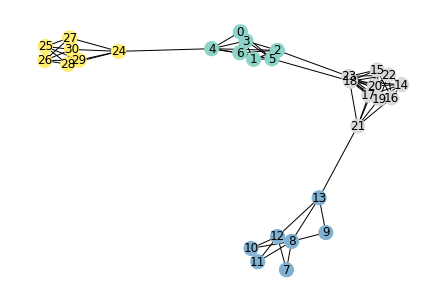

In [4]:
#graph generating
sizes = [7, 7, 10, 7]
probs = [[0.8, .02, .02, .02], [.02, 0.8, .02, .02], [0.02, 0.02, 0.8, .02], [.02, .02, .02, .8]]
true_labels=[]
i=0
for size in sizes:
    true_labels += ([i]*size)
    i += 1
G = nx.stochastic_block_model(sizes, probs, seed=212)
# nx.draw(G, node_size=200)
# plt.figure(figsize=(9,9))
nx.draw(G, node_color=true_labels, cmap=plt.cm.Set3, with_labels=True, node_size=200)
plt.show()

In [11]:
pos = nx.kamada_kawai_layout(G)
posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
posdf.head()

,X,Y
0,0.496661,-0.074463
1,0.366762,0.166559
2,0.174541,0.011736
3,0.248484,-0.251771
4,0.386230,-0.259433


# Node distribution

In [74]:
def distance(x1, y1, x2, y2):
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

# Function to calculate sum over all pairs of nodes
def sum_inverse_distances(node_df):
    total_sum = 0
    for (i, row_i), (j, row_j) in itertools.combinations(node_df.iterrows(), 2):
        dij = distance(row_i['X'], row_i['Y'], row_j['X'], row_j['Y'])
        if dij != 0:  # Avoid division by zero
            total_sum += 1 / dij**2
    return total_sum

# Calculate sum over all pairs of nodes
sum_inverse_distances(posdf)

106.92346810406363

# Distance to borderlines

In [31]:
def distance(x1, y1, x2, y2):
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

def calculate_sum(df):
    total_sum = 0
    for index, row in df.iterrows():
        x, y = row['X'], row['Y']
        # Calculate distances to sides
        ri = 1 - x  
        li = 1 + x  
        ti = 1 - y  
        bi = 1 + y  
        # to avoid diving by zero
        ri += .01 if ri==0 else ri
        ti += .01 if ti==0 else ti
        li += .01 if li==0 else li
        bi += .01 if bi==0 else bi

        total_sum += (1 / (ri ** 2) + 1 / (ti ** 2) + 1 / (li ** 2) + 1 / (bi ** 2))
    return round(total_sum/1000, 3)

calculate_sum(posdf)


23.139

# Edges length

In [32]:
def distance(x1, y1, x2, y2):
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

# Function to calculate sum of edge lengths
def calculate_edge_length_sum(graph, vertex_df):
    total_length = 0
    for u, v in graph.edges():
        x1, y1 = vertex_df.loc[u, ['X', 'Y']]
        x2, y2 = vertex_df.loc[v, ['X', 'Y']]
        edge_length = distance(x1, y1, x2, y2)
        total_length += edge_length
    return total_length

# Calculate sum of edge lengths
edge_length_sum = calculate_edge_length_sum(G, posdf)

In [33]:
edge_length_sum

20.761496019863316

# Node to Edge distances

In [103]:
def point_to_segment_distance(x, y, x1, y1, x2, y2):
    dx, dy = x2 - x1, y2 - y1
    length_squared = dx * dx + dy * dy
    t = max(0, min(1, ((x - x1) * dx + (y - y1) * dy) / length_squared))
    proj_x, proj_y = x1 + t * dx, y1 + t * dy
    return ((x - proj_x) ** 2 + (y - proj_y) ** 2) ** 0.5

# Function to calculate contribution of distance between a node and an edge
def edge_node_distance_contribution(G, pos_df, lam5=.1):
    total_contribution = 0
    g_min = 5 #cannot be more, the plane is restricted to -1 to 1
    for node in G.nodes():
        x_node, y_node = pos_df.loc[node, 'X'], pos_df.loc[node, 'Y']
        for u, v in G.edges():
            #if node in the edge - skip 
            if node == u or node == v:
                continue
            else:
                x1, y1 = pos_df.loc[u, 'X'], pos_df.loc[u, 'Y']
                x2, y2 = pos_df.loc[v, 'X'], pos_df.loc[v, 'Y']
                distance = point_to_segment_distance(x_node, y_node, x1, y1, x2, y2)
                if distance < g_min:
                    g_min = distance
                contribution = lam5 / (distance ** 2) if distance != 0 else 0  # Avoid division by zero
                total_contribution += contribution
    lam4 = lam5/g_min**2 
    return (total_contribution, lam4)

# Calculate contribution of distance between nodes and edges
edge_node_distance_contribution(G, posdf)


(67.86577106379202, 28.230546299735728)

In [104]:
(_, lam4) = edge_node_distance_contribution(G, posdf)
lam4

28.230546299735728

# Edge itersections

In [105]:
def intersect(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2

    # Calculate slopes
    slope1 = (y2 - y1) / (x2 - x1) if (x2 - x1) != 0 else float('inf')
    slope2 = (y4 - y3) / (x4 - x3) if (x4 - x3) != 0 else float('inf')
    # Calculate intercepts
    intercept1 = y1 - slope1 * x1 if slope1 != float('inf') else x1
    intercept2 = y3 - slope2 * x3 if slope2 != float('inf') else x3
    # Check if segments are parallel
    if slope1 == slope2:
        return False
    # Calculate intersection point
    x_intersect = (intercept2 - intercept1) / (slope1 - slope2)
    y_intersect = slope1 * x_intersect + intercept1
    # Check if intersection point lies within both line segments
    if min(x1, x2) <= x_intersect <= max(x1, x2) and \
       min(x3, x4) <= x_intersect <= max(x3, x4) and \
       min(y1, y2) <= y_intersect <= max(y1, y2) and \
       min(y3, y4) <= y_intersect <= max(y3, y4):
        return True
    return False

# Function to calculate number of edge crossings
def count_edge_crossings(graph, pos_df, lam4):
    crossings = 0
    # lam4 = lam5/g_min**2

    for (u1, v1), (u2, v2) in itertools.combinations(graph.edges(), 2):
        if len(set([u1, v1, u2, v2])) != 4:
            continue
        else:
            line1 = (pos_df.loc[u1, 'X'], pos_df.loc[u1, 'Y'], pos_df.loc[v1, 'X'], pos_df.loc[v1, 'Y'])
            line2 = (pos_df.loc[u2, 'X'], pos_df.loc[u2, 'Y'], pos_df.loc[v2, 'X'], pos_df.loc[v2, 'Y'])
            if intersect(line1, line2):
                crossings += 1
                # print(u1, v1)
                # print(u2, v2)
                # print('crossed')
    return lam4*crossings**2  


In [106]:
count_edge_crossings(G, posdf, lam4)

0.0

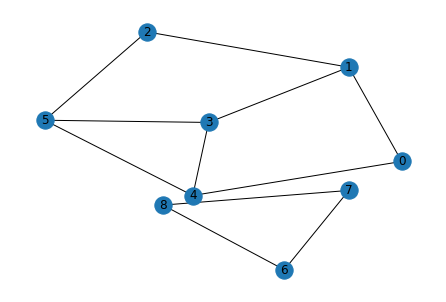

In [107]:
nx.draw(G, pos, with_labels=True)

# TESTING

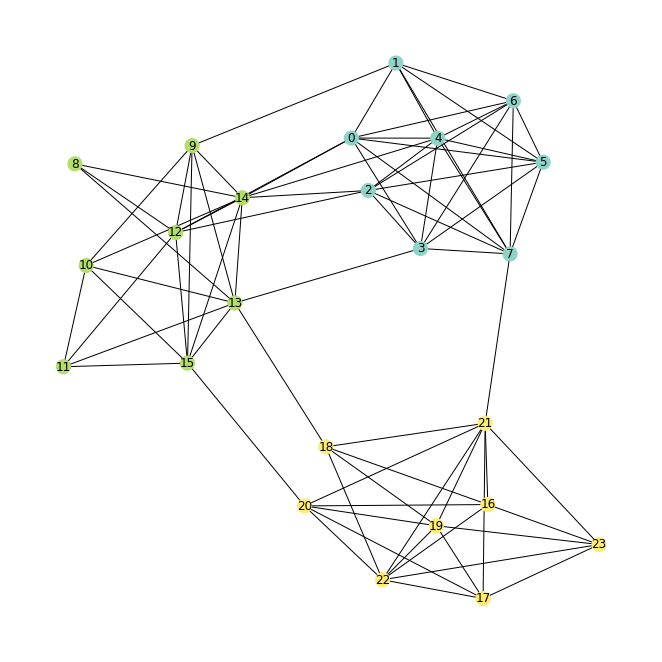

In [66]:
#graph generating
sizes = [8, 8, 8]
probs = [[0.8, .05, .05], [.05, .8, .05], [.05, .05, .8]]
true_labels=[]
i=0
for size in sizes:
    true_labels += ([i]*size)
    i += 1
G = nx.stochastic_block_model(sizes, probs, seed=212)

pos = nx.kamada_kawai_layout(G)
posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
# nx.draw(G, node_size=200)
plt.figure(figsize=(9,9))
nx.draw(G, pos,  node_color=true_labels, cmap=plt.cm.Set3, with_labels=True, node_size=200)
plt.show()

In [69]:
crossings = count_edge_crossings(G, posdf)
print("Number of edge crossings:", crossings)

Number of edge crossings: 109


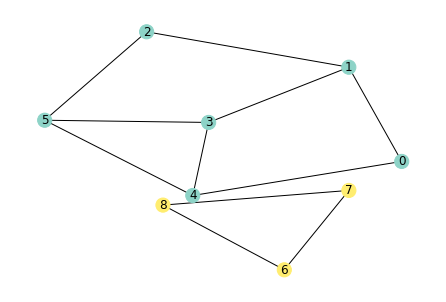

In [77]:
#graph generating
sizes = [6, 3]
probs = [[0.5, .01], [.01, 0.5]]
true_labels=[]
i=0
for size in sizes:
    true_labels += ([i]*size)
    i += 1
G = nx.stochastic_block_model(sizes, probs, seed=212)

pos = nx.kamada_kawai_layout(G)
posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
# nx.draw(G, node_size=200)
# plt.figure(figsize=(9,9))
nx.draw(G, pos,  node_color=true_labels, cmap=plt.cm.Set3, with_labels=True, node_size=200)
plt.show()

In [71]:
count_edge_crossings(G, posdf)


0